# Tree Methods Consulting Project 

You've been hired by a dog food company to try to predict why some batches of their dog food are spoiling much quicker than intended! Unfortunately this Dog Food company hasn't upgraded to the latest machinery, meaning that the amounts of the five preservative chemicals they are using can vary a lot, but which is the chemical that has the strongest effect? The dog food company first mixes up a batch of preservative that contains 4 different preservative chemicals (A,B,C,D) and then is completed with a "filler" chemical. The food scientists beelive one of the A,B,C, or D preservatives is causing the problem, but need your help to figure out which one!
Use Machine Learning with RF to find out which parameter had the most predicitive power, thus finding out which chemical causes the early spoiling! So create a model and then find out how you can decide which chemical is the problem!

* Pres_A : Percentage of preservative A in the mix
* Pres_B : Percentage of preservative B in the mix
* Pres_C : Percentage of preservative C in the mix
* Pres_D : Percentage of preservative D in the mix
* Spoiled: Label indicating whether or not the dog food batch was spoiled.
___

**Think carefully about what this problem is really asking you to solve. While we will use Machine Learning to solve this, it won't be with your typical train/test split workflow. If this confuses you, skip ahead to the solution code along walk-through!**
____

# Start

First thing is starting a new spark session. Let's call it dogfood:

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('dogfood').getOrCreate()

Next is reading the data, which is in a csv file:

In [2]:
df = spark.read.csv('input data/dog_food.csv', header=True, inferSchema=True)

df.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)



One can look at some of the values of these 4 columns and label in each row:

In [3]:
for s in df.head(3):
    print(s)
    print('-------')
    print('\n')

Row(A=4, B=2, C=12.0, D=3, Spoiled=1.0)
-------


Row(A=5, B=6, C=12.0, D=7, Spoiled=1.0)
-------


Row(A=6, B=2, C=13.0, D=6, Spoiled=1.0)
-------




Let's print the columns again tu use them in the VectorAssembler

In [4]:
df.columns

['A', 'B', 'C', 'D', 'Spoiled']

The model that will be used requires our data to be in a given format so let's use the VectorAssembler in order to do that:

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

assembler = VectorAssembler(inputCols=['A', 'B', 'C', 'D'],
                               outputCol='features')
output = assembler.transform(df)
output.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)
 |-- features: vector (nullable = true)



Now that there is a features vector and a Spoiled label the model can be created.

A RandomForestClassifier will be used:

In [6]:
from pyspark.ml.classification import (RandomForestClassifier,
                                           DecisionTreeClassifier)

rfc = RandomForestClassifier(labelCol='Spoiled', featuresCol='features')

After selecting the features vector and the label column the model can be trained using the fit method:

In [7]:
data = output.select('features', 'Spoiled')
rfc_model = rfc.fit(data)

As it was asked, the chemical with more influence can be obtained using featureImportances, wich reaturns a SparseVector:

In [8]:
rfc_model.featureImportances

SparseVector(4, {0: 0.0196, 1: 0.0212, 2: 0.9185, 3: 0.0406})

Looking at the above cell it is easy to conclude that number 2 (which corresponds to chemical C) is by far the most important feature.

Nevertheless, a plot of these feature importances is shown below:

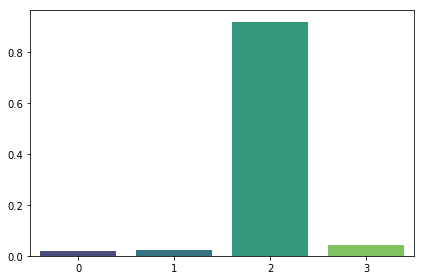

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.barplot(x=rfc_model.featureImportances.indices,
            y=rfc_model.featureImportances.values,
            palette='viridis')

plt.tight_layout()

Machine learning models can be used in multiple ways and this was just an alternative approach as teh goal was to check which feature drives the causation of whether or not the dog food is spoiled.

Thank you!